# Calibrated words analysis
Rubia Guerra

Last updated: Mar 31st 2022

### Module definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy import signal
from statsmodels.tsa import stattools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

plt.style.use("seaborn")

%matplotlib inline

In [2]:
data_dir = '../EEG/data/p*'
subject_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_calibrated_values.mat'))
mat_contents = sio.loadmat(subject_data_files[1])


### Import data

In [3]:
def load_and_split_dataset(data_dir = '../EEG/data/p*', split_size=100, random_seed=128, split_ratio = .7, subject_choice_seed=128):
    subject_data_files = glob.glob(os.path.join(data_dir, 'calibrated_words_calibrated_values.mat'))
    subject_data_files.sort()
    num_subjects = int(len(subject_data_files) * split_ratio)
    
    # group data, pick subjects randomly
    np.random.seed(subject_choice_seed)
    all_subjects = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    subjects = re.findall('p\d+', ''.join(all_subjects))
    print(f"Training set participants: {subjects}")
    
    train = []
    test = []
    for subject_filename in subject_data_files:
        mat_contents = sio.loadmat(subject_filename)
        mat_contents = np.hstack(mat_contents['var'])
        df = pd.DataFrame(mat_contents, columns=['Calibrated values'])
        
        if subject_filename in all_subjects:
            train.append(df)
        else:
            test.append(df)
    
    return train, test


In [4]:
[train, test] = load_and_split_dataset()

Training set participants: ['p23', 'p22', 'p2', 'p10', 'p5', 'p8', 'p7', 'p12', 'p17', 'p6', 'p4']


### Defining emotion dynamics features
Refer to _Houben M, Van Den Noortgate W, Kuppens P. The relation between short-term emotion dynamics and psychological well-being: A meta-analysis. Psychological bulletin. 2015 Jul;141(4):901._

- **Emotional inertia:** refers to how well the intensity of an emotional state can be predicted from the emotional state at a previous moment.
- **Emotional instability:** refers to the magnitude of emotional changes from one moment to the next. An individual characterized by high levels of instability experiences larger emotional shifts from one moment to the next, resulting in a more unstable emotional life.
- **Emotional variability:** refers to the range or amplitude of someone’s emotional states across time. An individual characterized by higher levels of emotional variability experiences emotions that reach more extreme levels and shows larger emotional deviations from his or her average emotional level

In [5]:
class EmotionDynamics:
    def __init__(self, Fs=0.05, interval=300):
        self.lag = int(Fs*interval*1e-1) # feeltrace sampling rate x 300 ms

    def emotional_variability(self, X):
        return np.std(X)

    def emotional_instability(self, X):
        return np.sum((X[1:] - X[:-1])**2)/(len(X)-1) # MSSD

    def emotional_inertia(self, X, lag=None):
        if lag is None:
            lag = self.lag
        return stattools.acf(X, nlags=lag)[lag] # Autocorrelation
    
    def get_parameters(self, X):
        X = np.array(X)
        parameters = {'Inertia':'', 'Instability':'', 'Variability':''}
        parameters['Inertia'] = self.emotional_inertia(X)
        parameters['Instability'] = self.emotional_instability(X)
        parameters['Variability'] = self.emotional_variability(X)
        return parameters

In [6]:
ED = EmotionDynamics()

In [7]:
ED.get_parameters(train[1]['Calibrated values'])

{'Inertia': -0.03766741071428572,
 'Instability': 43.098837209302324,
 'Variability': 4.51260859854213}

In [8]:
training_data = []
for subject in train:
    calibrated_values = np.array(subject['Calibrated values'])
    training_data.append(ED.get_parameters(calibrated_values))

In [9]:
test_data = []
for subject in test:
    feeltrace = np.array(subject['Calibrated values'])
    test_data.append(ED.get_parameters(calibrated_values))

In [10]:
X_train = pd.DataFrame(training_data)
X_test = pd.DataFrame(test_data)
X_train

,Inertia,Instability,Variability
0,-0.058245,47.391667,4.755631
1,-0.037667,43.098837,4.512609
2,0.240929,29.709677,4.354612
3,0.079935,23.877778,3.637669
4,-0.079603,29.575000,3.760806
5,0.009257,32.682432,4.020916
6,-0.032880,31.568750,3.862833
7,-0.202814,55.532609,4.748492
8,-0.005982,28.583333,3.787280
9,-0.091160,50.230769,4.737879


In [11]:
X = X_train.append(X_test).reset_index(drop=True)
X.head()

,Inertia,Instability,Variability
0,-0.058245,47.391667,4.755631
1,-0.037667,43.098837,4.512609
2,0.240929,29.709677,4.354612
3,0.079935,23.877778,3.637669
4,-0.079603,29.575000,3.760806


#### Data preprocessing: scaling
Standardize features by removing the mean and scaling to unit variance.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame(X_scaled, columns={'Inertia', 'Instability', 'Variability'}).head()

,Instability,Variability,Inertia
0,-0.768974,1.414996,1.538932
1,-0.561407,1.058040,1.131262
2,2.248768,-0.055290,0.866223
3,0.624836,-0.540222,-0.336451
4,-0.984411,-0.066489,-0.129887


#### Pairplot analysis

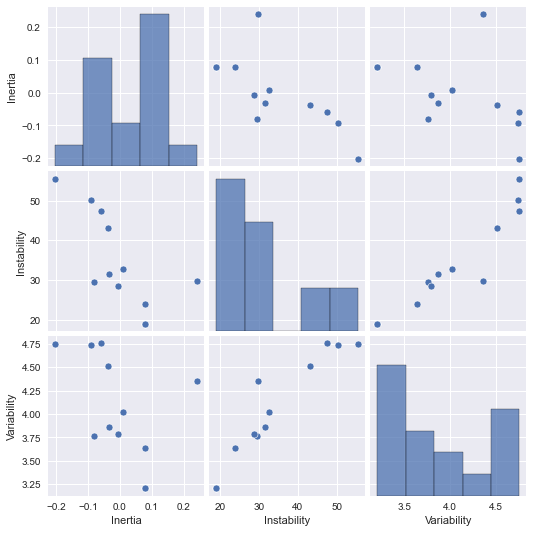

In [13]:
sns.pairplot(X);

### 3D scatterplot

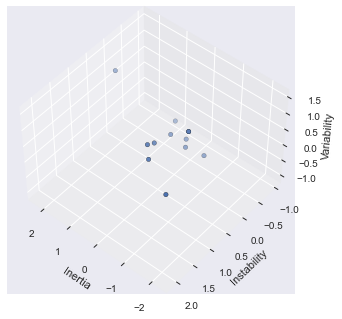

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=130, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.set_xlabel('Inertia')
ax.set_ylabel('Instability')
ax.set_zlabel('Variability')

plt.show()

### Principal Component Analysis

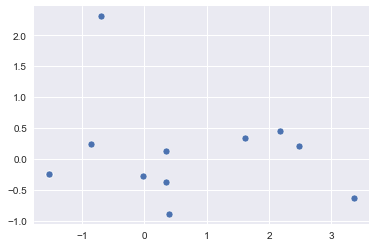

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_PCA = pca.transform(X_scaled)

sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1]);

### Gaussian Mixture Model

ValueError: expected square "a" matrix

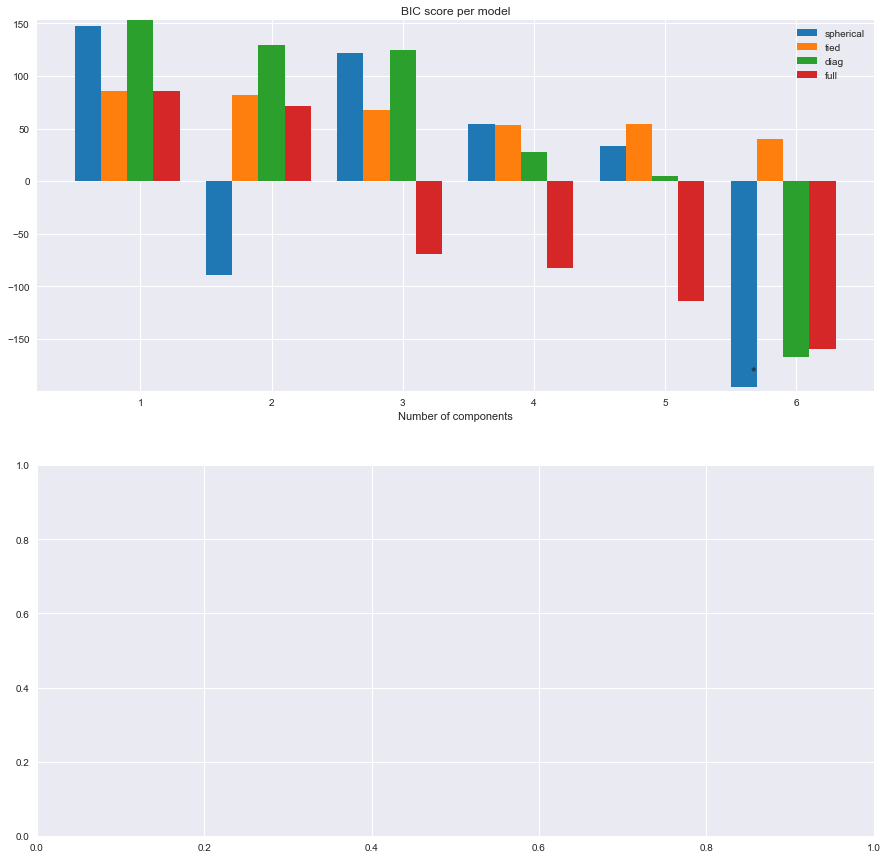

In [16]:
"""
================================
Gaussian Mixture Model Selection
================================

Gaussian Mixture Models using information-theoretic criteria (BIC).
Model selection concerns both the covariance type and the number of components in the model.
Unlike Bayesian procedures, such inferences are prior-free.

"""

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_scaled)
        bic.append(gmm.bic(X_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 15))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], 50, color=color)

plt.legend(range(len(clf.means_)))
plt.xlabel('Inertia')
plt.ylabel('Instability')
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.show()
